In [2]:
import numpy as np
import pandas as pd

/tmp/ipykernel_2626304/1662815981.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [60]:
recording = pd.read_csv('recording1.csv', 
    comment="#",        # skip lines starting with "#"
    skip_blank_lines=True,
    nrows=100000) # limit for testing; remove or set to None to process entire file)

In [61]:
recording.head()

,Time (s),DIO 0
0,-42.949673,0
1,-42.949672,0
2,-42.949672,0
3,-42.949672,0
4,-42.949671,0


In [9]:
print(recording.where(recording['DIO  0'] == 1).count())
print(recording.where(recording['DIO  0'] == 0).count())

Time (s)    65867554
DIO  0      65867554
dtype: int64
Time (s)    202567902
DIO  0      202567902
dtype: int64


In [ ]:
import pandas as pd
import numpy as np

path = "recording1.csv"
f_expected = 1000.0         # Hz
debounce_s = 0.000002       # 2 us, helps ignore spurious bounces; set to 0 to disable

edge_times = []
last_sample = None
last_time = None

for chunk in pd.read_csv(
    path,
    comment="#",
    usecols=["Time (s)", "DIO  0"],
    dtype={"Time (s)": "float64", "DIO  0": "int8"},
    chunksize=2_000_000,
    skip_blank_lines=True,
    nrows=10_000_000  # limit for testing; remove or set to None to process entire file
):
    t = chunk["Time (s)"].to_numpy()
    x = chunk["DIO  0"].to_numpy()

    # Ensure time is increasing; reverse if the file stores descending timestamps
    if t.size >= 2 and t[1] < t[0]:
        t = t[::-1]
        x = x[::-1]

    # Handle possible rising edge across chunk boundary
    if last_sample is not None and last_time is not None:
        # if last was 0 and first now is 1, count a rising edge at current first sample
        if last_sample == 0 and x[0] == 1:
            edge_times.append(t[0])

    # Rising edges within chunk using diffs
    # rising at i means x[i-1]==0 and x[i]==1  -> diff = +1 at index i
    dx = np.diff(x.astype(np.int8))
    edge_idx_all = np.flatnonzero((dx == 1) | (dx == -1)) + 1
    edge_idx_rise = np.flatnonzero(dx == 1) + 1
    edge_idx_fall = np.flatnonzero(dx == -1) + 1

    edge_t_all = t[edge_idx_all]
    edge_t_rise = t[edge_idx_rise]
    edge_t_fall = t[edge_idx_fall]

    last_sample = int(x[-1])
    last_time = float(t[-1])

edge_times = np.asarray(edge_times, dtype=np.float64)
if edge_times.size < 2:
    raise RuntimeError("Not enough edges detected.")

# Optional debounce: remove edges that occur too close together (e.g., noise)
if debounce_s > 0:
    dt = np.diff(edge_times)
    keep = np.ones(edge_times.size, dtype=bool)
    keep[1:] = dt >= debounce_s
    edge_times = edge_times[keep]

# Now compute stats
n = np.arange(edge_times.size, dtype=np.float64)
A = np.vstack([edge_times, np.ones_like(edge_times)]).T
f_slope, intercept = np.linalg.lstsq(A, n, rcond=None)[0]  # Hz
f_meas = f_slope

ppm = (f_meas - f_expected) / f_expected * 1e6
ms_per_min = ppm * 0.06

periods = np.diff(edge_times)
T_mean = periods.mean()
T_std = periods.std(ddof=1)
f_from_periods = 1.0 / T_mean
ppm_period = (f_from_periods - f_expected) / f_expected * 1e6

duration = edge_times[-1] - edge_times[0]

print(f"Detected rising edges (after debounce): {edge_times.size}")
print(f"Observed duration: {duration:.6f} s\n")

print("=== Frequency estimate (regression) ===")
print(f"Measured frequency: {f_meas:.6f} Hz")
print(f"Error: {ppm:.3f} ppm")
print(f"Equivalent drift: {ms_per_min:.3f} ms/min\n")

print("=== Period stats ===")
print(f"Mean period: {T_mean*1e3:.6f} ms")
print(f"Std period (jitter): {T_std*1e6:.3f} µs")
print(f"Frequency (1/mean period): {f_from_periods:.6f} Hz")
print(f"Error (from periods): {ppm_period:.3f} ppm")


Detected rising edges (after debounce): 720
Observed duration: 1.437934 s

=== Frequency estimate (regression) ===
Measured frequency: 500.022937 Hz
Error: -499977.063 ppm
Equivalent drift: -29998.624 ms/min

=== Period stats ===
Mean period: 1.999908 ms
Std period (jitter): 0.224 µs
Frequency (1/mean period): 500.022922 Hz
Error (from periods): -499977.078 ppm


In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Load only first 100k rows after skipping comments
df = pd.read_csv(
    "recording1.csv",
    comment="#",
    nrows=100_000_000
)

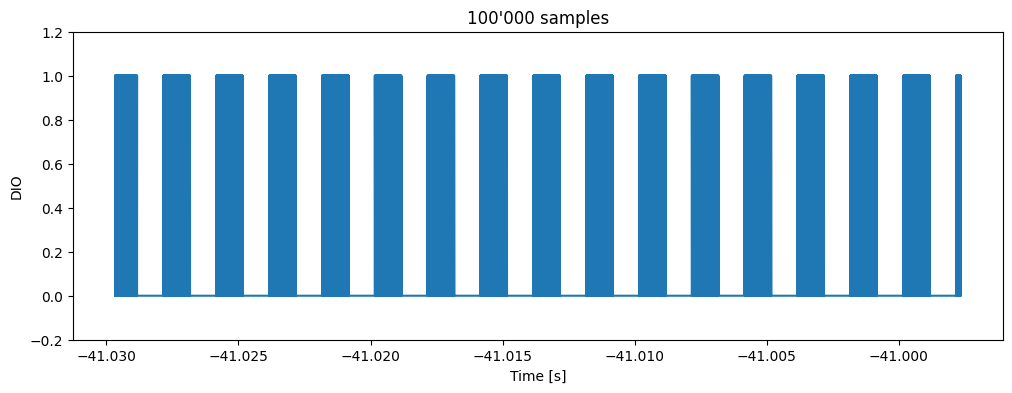

In [34]:

# Plot
plt.figure(figsize=(12,4))
plt.plot(df["Time (s)"][6_000_000:6_100_010], df["DIO  0"][6_000_000:6_100_010], drawstyle="steps-pre")
plt.xlabel("Time [s]")
plt.ylabel("DIO")
plt.title("100'000 samples")
plt.ylim(-0.2, 1.2)
plt.show()


fs ≈ 3125000.0 Hz | fc = 10000.0 Hz
Edges in view (after filter+Schmitt): rising=0, falling=1


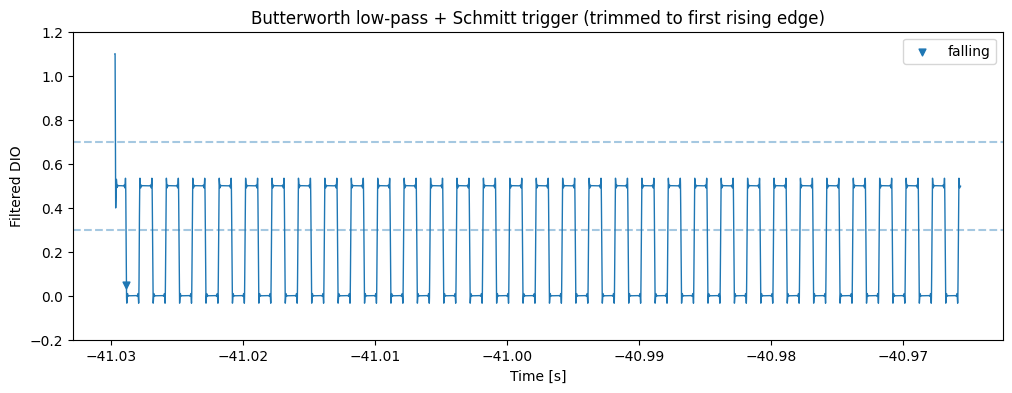

In [44]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Try SciPy; fallback to a moving-average if not installed
try:
    from scipy.signal import butter, filtfilt
    HAVE_SCIPY = True
except Exception:
    HAVE_SCIPY = False

path = "recording1.csv"

# ---- Helpers ----
def parse_samplerate_from_header(p):
    fs = None
    with open(p, "r") as f:
        for line in f:
            if not line.startswith("#"):
                break
            m = re.search(r"Sample rate:\s*([\d.+eE+-]+)\s*Hz", line)
            if m:
                fs = float(m.group(1))
    return fs

def butter_lowpass(x, fs, fc=10_000.0, order=4):
    """Zero-phase Butterworth LPF."""
    if not HAVE_SCIPY:
        # Fallback: moving average ~ crude low-pass
        win = max(3, int(round(fs/(fc*8))))  # ~1/(8*fc) window
        return np.convolve(x, np.ones(win)/win, mode="same")
    Wn = fc / (fs * 0.5)
    b, a = butter(order, Wn, btype="low")
    return filtfilt(b, a, x)

def schmitt_edges(t, y, low_th=0.3, high_th=0.7):
    """
    Schmitt-trigger edge detection with linear interpolation of crossing time.
    Returns (rising_times, falling_times).
    """
    rises, falls = [], []
    # initial state
    state = y[0] >= high_th
    for i in range(1, len(y)):
        y0, y1 = y[i-1], y[i]
        t0, t1 = t[i-1], t[i]
        if not state:
            # look for crossing high_th upward
            if y0 < high_th <= y1 and y1 != y0:
                # linear interpolation time of crossing
                tc = t0 + (high_th - y0) * (t1 - t0) / (y1 - y0)
                rises.append(tc)
                state = True
        else:
            # look for crossing low_th downward
            if y0 > low_th >= y1 and y1 != y0:
                tc = t0 + (low_th - y0) * (t1 - t0) / (y1 - y0)
                falls.append(tc)
                state = False
    return np.asarray(rises), np.asarray(falls)

# ---- Load a window (adjust SLICE/NROWS as you like) ----
NROWS = 6_200_000
SLICE = slice(6_000_000, len(df))  # ~100k samples window for debug plot

df = pd.read_csv(
    path, comment="#", nrows=NROWS,
    usecols=["Time (s)", "DIO  0"],
    dtype={"Time (s)": "float64", "DIO  0": "int8"},
    skip_blank_lines=True,
)
t = df["Time (s)"].to_numpy()[SLICE]
x = df["DIO  0"].to_numpy()[SLICE].astype(float)

# Ensure increasing time
if t.size >= 2 and t[1] < t[0]:
    t = t[::-1]; x = x[::-1]

# Sample rate from header (fallback: estimate from data)
fs = parse_samplerate_from_header(path)
if fs is None:
    fs = 1.0 / np.median(np.diff(t))

# ---- Filter then detect ----
fc = 10_000.0   # try 10 kHz; if you still see spurs, drop to 5 kHz; if edges look rounded/missed, raise to 20 kHz
y = butter_lowpass(x, fs, fc=fc, order=4)
# Clamp tiny overshoot
y = np.clip(y, -0.1, 1.1)

# Schmitt thresholds (hysteresis)
low_th, high_th = 0.3, 0.7
rise_t, fall_t = schmitt_edges(t, y, low_th=low_th, high_th=high_th)

# Trim everything before first valid rising edge
if rise_t.size:
    t0 = rise_t[0]
    rise_t = rise_t[rise_t >= t0]
    fall_t = fall_t[fall_t >= t0]
    mask = t >= t0
    t_plot, y_plot = t[mask], y[mask]
else:
    t_plot, y_plot = t, y

print(f"fs ≈ {fs:.1f} Hz | fc = {fc:.1f} Hz")
print(f"Edges in view (after filter+Schmitt): rising={rise_t.size}, falling={fall_t.size}")

# ---- Plot debug ----
plt.figure(figsize=(12,4))
plt.plot(t_plot, y_plot, lw=1)
if rise_t.size: plt.scatter(rise_t, np.full_like(rise_t, 0.95), s=24, marker="^", label="rising")
if fall_t.size: plt.scatter(fall_t, np.full_like(fall_t, 0.05), s=24, marker="v", label="falling")
plt.axhline(low_th, ls="--", alpha=0.4)
plt.axhline(high_th, ls="--", alpha=0.4)
plt.ylim(-0.2, 1.2); plt.xlabel("Time [s]"); plt.ylabel("Filtered DIO")
plt.title("Butterworth low-pass + Schmitt trigger (trimmed to first rising edge)")
plt.legend(); plt.show()

# ---- (Optional) frequency & drift from rising edges (1 per cycle) ----
EXPECTED_HZ = 1000.0
if rise_t.size >= 2:
    periods = np.diff(rise_t)
    f_mean = 1.0 / periods.mean()
    ppm = (f_mean - EXPECTED_HZ) / EXPECTED_HZ * 1e6
    ms_per_min = ppm * 0.06
    print(f"f ≈ {f_mean:.6f} Hz | error ≈ {ppm:.3f} ppm | drift ≈ {ms_per_min:.3f} ms/min")


fs ≈ 3125000.000 Hz | min_zero_run ≈ 600 µs (≥ 1875 samples)
Detected edges: rising=42071, falling=42070
Estimated f: 500.022877 Hz | error: 45.754 ppm | drift: 2.745 ms/min


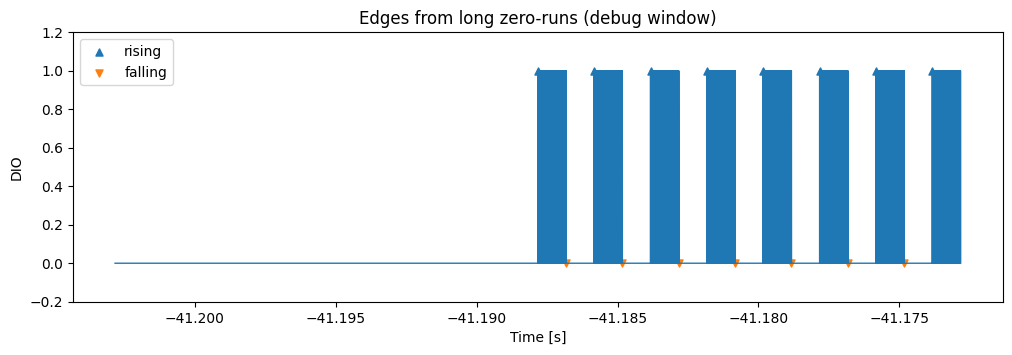

In [51]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

path = "recording1.csv"
min_zero_run_s = 0.0006      # 0.6 ms → treat as "solid low"
chunksize = 2_000_000        # adjust as you like
usecols = ["Time (s)", "DIO  0"]
EXPECTED_HZ = 500.0

def parse_samplerate_from_header(p):
    fs = None
    with open(p, "r") as f:
        for line in f:
            if not line.startswith("#"):
                break
            m = re.search(r"Sample rate:\s*([\d.+eE+-]+)\s*Hz", line)
            if m:
                fs = float(m.group(1))
                break
    return fs

fs = parse_samplerate_from_header(path)
if fs is None:
    # fallback: estimate from first chunk later
    pass

rising_times = []
falling_times = []

# Carry-over state for the open (last) run spanning chunks
open_val = None               # 0 or 1
open_start_time = None        # time of first sample of the open run
open_len = 0                  # length in samples
pending_rise_after_zero = False  # whether we just finished a solid-zero run and await the next 1 run to stamp the rising edge
saw_high_at_least_once = False   # to avoid emitting a falling edge before we ever had a high

last_time_prev_chunk = None   # optional sanity

reader = pd.read_csv(
    path, comment="#", usecols=usecols,
    dtype={"Time (s)": "float64", "DIO  0": "int8"},
    chunksize=chunksize, skip_blank_lines=True
)

for chunk_i, chunk in enumerate(reader):
    t = chunk["Time (s)"].to_numpy()
    x = chunk["DIO  0"].to_numpy()

    # Ensure increasing time (WaveForms often writes descending)
    if t.size >= 2 and t[1] < t[0]:
        t = t[::-1]; x = x[::-1]

    if fs is None:
        # estimate once from this (first) chunk
        fs = 1.0 / float(np.median(np.diff(t)))

    min_zero_run_samples = int(round(min_zero_run_s * fs))
    if min_zero_run_samples < 1:
        min_zero_run_samples = 1

    # Build run-length encoding for this chunk
    # change points
    chg = np.flatnonzero(np.diff(x) != 0) + 1
    run_starts = np.r_[0, chg]
    run_ends   = np.r_[chg, x.size]
    run_vals   = x[run_starts]
    run_tstart = t[run_starts]

    # If we have an open run coming from the previous chunk and it continues here, merge it
    if open_val is not None and run_vals.size > 0 and run_vals[0] == open_val:
        # replace first run's start time with the open run's start
        run_tstart[0] = open_start_time
        # extend first run length implicitly by remembering open_len; we only need it for zero-run decision
        open_extend = open_len
    else:
        open_extend = 0

    # We'll process all runs except the last one (it may be open and extend to next chunk)
    n_runs = run_vals.size
    last_index_to_finalize = max(0, n_runs - 1)

    for k in range(last_index_to_finalize):
        val = int(run_vals[k])
        start_idx = run_starts[k]
        end_idx   = run_ends[k]
        start_time = float(run_tstart[k])
        # effective length in samples (accounting for carry-in if k==0)
        eff_len = (end_idx - start_idx) + (open_extend if k == 0 else 0)

        if val == 0:
            # This is a finished zero run
            if eff_len >= min_zero_run_samples:
                # Mark falling edge at the first zero of this run (only if we had a high before)
                if saw_high_at_least_once:
                    falling_times.append(start_time)
                # Next time we enter a 1-run, stamp the rising edge
                pending_rise_after_zero = True
            # else: short zero glitch inside high → ignore
        else:  # val == 1
            # This is a finished one run
            if pending_rise_after_zero:
                # The rising edge is at the first sample of this 1-run
                rising_times.append(start_time)
                pending_rise_after_zero = False
                saw_high_at_least_once = True

    # Save the last (open) run to merge with next chunk
    if n_runs > 0:
        open_val = int(run_vals[-1])
        open_start_time = float(run_tstart[-1])
        # compute its length so far (without carry-in; carry will be recomputed next loop)
        open_len = int(run_ends[-1] - run_starts[-1])
    else:
        # chunk empty (shouldn't happen)
        pass

# Finalize file end:
# If the file ends in a long zero run, we should emit its falling edge (if we had a high before).
# We can't emit a rising because there's no following 1.
if open_val == 0 and open_len >= int(round(min_zero_run_s * fs)):
    if saw_high_at_least_once:
        falling_times.append(open_start_time)

rising_times = np.asarray(rising_times, dtype=np.float64)
falling_times = np.asarray(falling_times, dtype=np.float64)

# Trim everything before the first rising edge (optional but usually desired)
if rising_times.size:
    t0 = rising_times[0]
    rising_times = rising_times[rising_times >= t0]
    falling_times = falling_times[falling_times >= t0]

print(f"fs ≈ {fs:.3f} Hz | min_zero_run ≈ {min_zero_run_s*1e6:.0f} µs "
      f"(≥ {int(round(min_zero_run_s*fs))} samples)")
print(f"Detected edges: rising={rising_times.size}, falling={falling_times.size}")

# --- Frequency / drift using rising edges (one per cycle) ---
if rising_times.size >= 2:
    duration = rising_times[-1] - rising_times[0]
    
    cycles = rising_times.size - 1
    f_est = cycles / duration
    ppm = (f_est - EXPECTED_HZ) / EXPECTED_HZ * 1e6
    ms_per_min = ppm * 0.06
    print(f"Estimated f: {f_est:.6f} Hz | error: {ppm:.3f} ppm | drift: {ms_per_min:.3f} ms/min")

# --- Quick debug plot on a small window around the first few edges ---
if rising_times.size:
    # pick 30 ms around first rising edge
    t_center = rising_times[0]
    # reload a small window for plotting
    window = 0.03   # 30 ms
    df_dbg = pd.read_csv(
        path, comment="#", usecols=usecols,
        dtype={"Time (s)":"float64","DIO  0":"int8"},
        skip_blank_lines=True
    )
    td = df_dbg["Time (s)"].to_numpy()
    xd = df_dbg["DIO  0"].to_numpy()
    # ensure increasing
    if td.size >= 2 and td[1] < td[0]:
        td = td[::-1]; xd = xd[::-1]
    mask = (td >= t_center - window/2) & (td <= t_center + window/2)
    td = td[mask]; xd = xd[mask]
    plt.figure(figsize=(12,3.5))
    plt.plot(td, xd, drawstyle="steps-pre", lw=1)
    rmask = (rising_times >= td[0]) & (rising_times <= td[-1])
    fmask = (falling_times >= td[0]) & (falling_times <= td[-1])
    plt.scatter(rising_times[rmask], np.ones(rising_times[rmask].size), marker="^", s=26, label="rising")
    plt.scatter(falling_times[fmask], np.zeros(falling_times[fmask].size), marker="v", s=26, label="falling")
    plt.ylim(-0.2, 1.2); plt.xlabel("Time [s]"); plt.ylabel("DIO")
    plt.title("Edges from long zero-runs (debug window)")
    plt.legend(); plt.show()


In [56]:
print(rising_times[-1] - rising_times[0])
print(df["Time (s)"].max())
print(df["Time (s)"].min())

84.13615039999999
-40.96567296
-42.94967264


In [50]:
EXPECTED_HZ = 500.0
edges = np.sort(np.concatenate([rising_times, falling_times]))
if edges.size >= 3:
    # 1) Regression: each edge advances 0.5 cycles
    n_cycles = 0.5 * np.arange(edges.size, dtype=np.float64)
    A = np.vstack([edges, np.ones_like(edges)]).T
    f_reg, intercept = np.linalg.lstsq(A, n_cycles, rcond=None)[0]   # cycles/sec
    ppm_reg = (f_reg - EXPECTED_HZ) / EXPECTED_HZ * 1e6
    ms_per_min_reg = ppm_reg * 0.06

    # 2) Period stats:
    half_periods = np.diff(edges)                      # consecutive edges (~0.5 ms)
    cycle_periods = edges[2:] - edges[:-2]            # every other edge (~1 ms)

    f_from_half = 1.0 / (2.0 * half_periods.mean())   # cycles/sec
    f_from_cycle = 1.0 / cycle_periods.mean()         # cycles/sec (equivalent)

    jitter_half_us = half_periods.std(ddof=1) * 1e6   # half-period jitter
    jitter_cycle_us = cycle_periods.std(ddof=1) * 1e6 # cycle jitter

    ppm_half  = (f_from_half  - EXPECTED_HZ) / EXPECTED_HZ * 1e6
    ppm_cycle = (f_from_cycle - EXPECTED_HZ) / EXPECTED_HZ * 1e6

    print("=== Frequency using BOTH edges ===")
    print(f"Regression:     {f_reg:.6f} Hz   error {ppm_reg:.3f} ppm   drift {ms_per_min_reg:.3f} ms/min")
    print(f"From ½-periods: {f_from_half:.6f} Hz   error {ppm_half:.3f} ppm   jitter(½) {jitter_half_us:.3f} µs")
    print(f"From periods:   {f_from_cycle:.6f} Hz   error {ppm_cycle:.3f} ppm   jitter(1T) {jitter_cycle_us:.3f} µs")
else:
    print("Not enough edges to compute frequency with both-edge method.")

=== Frequency using BOTH edges ===
Regression:     500.022879 Hz   error 45.757 ppm   drift 2.745 ms/min
From ½-periods: 500.022877 Hz   error 45.754 ppm   jitter(½) 1.752 µs
From periods:   500.022879 Hz   error 45.759 ppm   jitter(1T) 0.224 µs


In [62]:
import pandas as pd
t = pd.read_csv("recording1.csv", comment="#", usecols=["Time (s)"])["Time (s)"]
print("start", t.iloc[0], "end", t.iloc[-1], "duration", t.iloc[-1]-t.iloc[0])

start -42.94967264 end 42.94967296 duration 85.8993456
